In [1]:
sc

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools
import copy
from joblib import Parallel, delayed
import multiprocessing
import pickle
import scipy.optimize as sco

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import predictions_ALS
from models.means import *
from models.medians import *
from models.helpers import *
from models.collaborative_filtering import *
from models.MF_SGD import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100
sc.setCheckpointDir('./checkpoint/')


In [3]:
train = load_csv()
train.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [4]:
models = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },
    'user_mean': {
        'compute_predictions': True,
        'function': user_mean,
        'params': {}
    },
    'movie_mean': {
        'compute_predictions': True,
        'function': movie_mean,
        'params': {}
    },
    'global_median': {
        'compute_predictions': True,
        'function': global_median,
        'params': {}    
    },  
    'user_median': {
        'compute_predictions': True,
        'function': user_median,
        'params': {}
    },
    'movie_median': {
        'compute_predictions': True,
        'function': movie_median,
        'params': {}
    }
}

models2 = {
    'movie_mean_deviation_user': {
        'compute_predictions': True,
        'function': movie_mean_deviation_user,
        'params': {}
    },
    'movie_median_deviation_user': {
        'compute_predictions': True,
        'function': movie_median_deviation_user,
        'params': {}
    }
}

models3 = {
    'als': {
        'compute_predictions': True,
        'function': predictions_ALS,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },
    'collab_filt': {
        'compute_predictions': True,
        'function': collaborative_filtering,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }
}

models4 = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },  
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }   
}

# add by Jo
models5 = {
        'mf_sgd_rescale': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD_rescaling,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }
}

models = dict(models, **models2)

models = dict(models, **models3)

# add by Jo
models = dict(models, **models5)

In [5]:
def prepare_blending(data, k_folds, models):
    blending = CrossValidationBlending(data, k_folds)
    for key in models.keys():
        blending.add_model(models[key]['function'], key)
    return blending

def add_param_blending(blending, models):
    for key in models.keys():
        blending.add_params_for_model(key, models[key]['params'], compute_predictions=models[key]['compute_predictions'])
        
    return blending

def test_blending(blending, best_dict, models):
    dict_try = {}
    for key in models.keys():
        dict_try[key] = 0
        
    for key in models.keys():
        dict_test = dict_try.copy()
        dict_test[key] = 1
        rmse = blending.evaluate_blending(dict_test)
        print("RMSE for model %s: %.5f"%(key, rmse))
        
    print()
    rmse = blending.evaluate_blending(best_dict)
    print("Best blending: %s"%best_dict)
    print("RMSE best blending: %.5f"%rmse)
    
def prediction(train, blending, best_dict, output):
    test = pd.read_csv('../data/sampleSubmission.csv')
    test_prep = test
    test_prep['User'] = test_prep['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    test_prep['Movie'] = test_prep['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    test_prep['Rating'] = test_prep['Prediction']
    test_prep = test_prep.drop(['Prediction', 'Id'], axis=1)
    
    pred = blending.evaluate_blending_for_validation(best_dict, train, test_prep)
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5
        elif pred[i] < 1:
            pred[i] = 1
    
    test.Rating=pred
    test['Prediction']=test.Rating
    test = test.drop(['User', 'Movie', 'Rating'], axis=1)
    test.to_csv(output, index=False)
    
def eval_(x, blending, models):
    dict_try = {}
    for idx, key in enumerate(models.keys()):
        dict_try[key] = x[idx] 
        
    return blending.evaluate_blending(dict_try)

In [6]:
blending = prepare_blending(train, 5, models)

In [7]:
blending = add_param_blending(blending, models)

[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9885049026291648
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9886749951196526
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9882599750965839
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9887865572053464
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9875863060117469
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9899415819366403
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9901106079769219
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, itera

/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done


In [8]:
x0 = np.zeros(len(models.keys()))
x0[0]=1
eval_(x0, blending, models)

1.0952830412161259

In [9]:
models.keys()

dict_keys(['user_mean', 'mf_sgd_rescale', 'mf_sgd', 'als', 'movie_mean_deviation_user', 'movie_median', 'movie_mean', 'movie_median_deviation_user', 'user_median', 'collab_filt', 'global_median', 'global_mean'])

In [10]:
# x0 = [-3.50217241, -0.34302467,  1.03720384, -0.32505441, -4.12058282,
#         0.61916421,  4.08423545, -0.02151008,  0.06576934,  3.88763932,
#        -0.51662585]

#x0 = [-3.50217241, -0.17, -0.17,  1.03720384, -0.32505441, -4.12058282,
#        0.61916421,  4.08423545, -0.02151008,  0.06576934,  3.88763932,
#       -0.51662585]

x0 = [-2.99077953,  0.50838123, -0.27641594,  0.62630672, -0.81644207,
       -3.98709989,  0.91659852,  3.97836857, -0.01195157,  0.04861974,
        3.3481853 , -0.46744658]
res = sco.minimize(eval_, x0, method='Nelder-Mead', args=(blending, models), options={'maxiter':1000, 'disp':True})

In [11]:
res

 final_simplex: (array([[-3.32899363,  0.14579114, -0.36941329,  0.93064264, -0.43713107,
        -3.98310197,  0.64757694,  3.99568199,  0.01840276,  0.07213845,
         3.7310843 , -0.55721718],
       [-3.31872483,  0.16123585, -0.37962888,  0.92602217, -0.44867952,
        -3.98264717,  0.66101166,  3.99312091,  0.01982961,  0.07099824,
         3.72453614, -0.56144729],
       [-3.32223038,  0.16177582, -0.38789812,  0.9257983 , -0.44635097,
        -3.98505047,  0.66002567,  3.99966842,  0.02114229,  0.0743403 ,
         3.717214  , -0.55259666],
       [-3.31906575,  0.16132709, -0.38039431,  0.92709595, -0.44748412,
        -3.98221498,  0.6572756 ,  3.99471882,  0.0192121 ,  0.07054131,
         3.72345863, -0.5587854 ],
       [-3.31845697,  0.17257525, -0.39599432,  0.9264143 , -0.45859675,
        -3.98910194,  0.67098722,  4.00181838,  0.02138858,  0.074966  ,
         3.7107244 , -0.55072472],
       [-3.31220488,  0.17132657, -0.38013751,  0.9247909 , -0.45971076,
     

In [12]:
dict_opt = {}
for idx, key in enumerate(models.keys()):
    dict_opt[key] = res.x[idx]
dict_opt

{'als': 0.93064263544827197,
 'collab_filt': 0.072138454329560925,
 'global_mean': -0.55721718497340977,
 'global_median': 3.7310842984251371,
 'mf_sgd': -0.36941329226630759,
 'mf_sgd_rescale': 0.14579113936950661,
 'movie_mean': 0.64757693981387776,
 'movie_mean_deviation_user': -0.43713107140237706,
 'movie_median': -3.9831019673849966,
 'movie_median_deviation_user': 3.9956819864991129,
 'user_mean': -3.3289936341580812,
 'user_median': 0.018402764632486968}

In [13]:
test_blending(blending, dict_opt, models)

RMSE for model user_mean: 1.09528
RMSE for model mf_sgd_rescale: 0.99991
RMSE for model mf_sgd: 1.00061
RMSE for model als: 0.98900
RMSE for model movie_mean_deviation_user: 0.99654
RMSE for model movie_median: 1.10003
RMSE for model movie_mean: 1.03045
RMSE for model movie_median_deviation_user: 1.05817
RMSE for model user_median: 1.15175
RMSE for model collab_filt: 1.02779
RMSE for model global_median: 1.12812
RMSE for model global_mean: 1.11906

Best blending: {'user_mean': -3.3289936341580812, 'mf_sgd_rescale': 0.14579113936950661, 'mf_sgd': -0.36941329226630759, 'als': 0.93064263544827197, 'movie_mean_deviation_user': -0.43713107140237706, 'movie_median': -3.9831019673849966, 'movie_mean': 0.64757693981387776, 'movie_median_deviation_user': 3.9956819864991129, 'user_median': 0.018402764632486968, 'collab_filt': 0.072138454329560925, 'global_median': 3.7310842984251371, 'global_mean': -0.55721718497340977}
RMSE best blending: 0.96305


In [14]:
# i don't know if it works... to clear sp context order to avoid error in 'prediction' method
sqlContext = SQLContext.getOrCreate(SparkContext.getOrCreate())

sqlContext.clearCache()

In [15]:
prediction(train, blending, dict_opt, 'pred_blending_2.csv')

[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9895411617478957
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9908975630629757
[MF-SGD] Done
[ALS] applying
[ALS] done
[MOVIE_MEAN_DEVIATION_USER] applying
[MOVIE_MEAN_DEVIATION_USER] done
[MOVIE_MEDIAN] applying
[MOVIE_MEDIAN] done
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[USER_MEDIAN] applying
[USER_MEDIAN] done
[COLLABORATIVE FILTERING] applying


/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done


In [16]:
df = pd.read_csv('pred_blending_2.csv')
df.head()


,Id,Prediction
0,r37_c1,3.277073
1,r73_c1,3.073035
2,r156_c1,3.781512
3,r160_c1,3.313124
4,r248_c1,3.580175


In [17]:
pred = list(df.Prediction)

(array([  6.40000000e+01,   8.10000000e+01,   2.30000000e+02,
          5.58000000e+02,   1.23900000e+03,   2.66900000e+03,
          5.54800000e+03,   1.04230000e+04,   1.99390000e+04,
          3.47120000e+04,   5.83140000e+04,   8.87750000e+04,
          1.23490000e+05,   1.54553000e+05,   1.74934000e+05,
          1.72503000e+05,   1.45574000e+05,   1.01665000e+05,
          5.46940000e+04,   2.69870000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

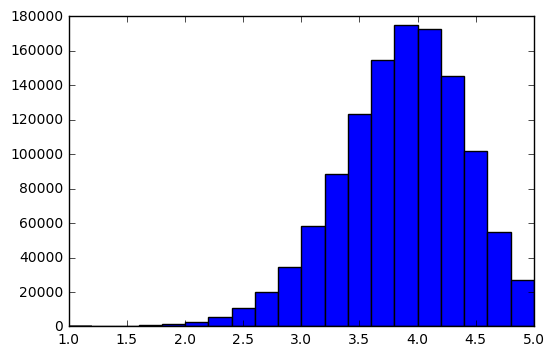

In [18]:
plt.hist(pred, bins=20)